In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

In [ ]:
import kagglehub

path = kagglehub.dataset_download("kambingbersayaphitam/speech-dataset-of-human-and-ai-generated-voices")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/speech-dataset-of-human-and-ai-generated-voices


In [ ]:
print("Base path contents:", os.listdir(path))

Base path contents: ['Fake', 'Real', 'Dataset.csv']


In [ ]:
def load_and_preprocess_data(path_audio, label):
    audio, sr = librosa.load(path_audio, sr=None, duration=5.0)  # only use first 5 seconds
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=512)
    return mfccs.T, label


In [ ]:
def prepare_dataset(real_path, fake_path):
    x, y = [], []
    for path in real_path:
        features, label = load_and_preprocess_data(path, 0)
        x.append(features)
        y.append(label)
    for path in fake_path:
        features, label = load_and_preprocess_data(path, 1)
        x.append(features)
        y.append(label)
    return x, np.array(y)

In [ ]:
def augment_data(x, y):
    augmented_x, augmented_y = [], []
    for features, label in zip(x, y):
        augmented_x.append(features)
        augmented_y.append(label)

        audio_signal = librosa.effects.time_stretch(features.T[0], rate=0.8)
        augmented_x.append(librosa.feature.mfcc(y=audio_signal, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)

        audio_signal_shifted = librosa.effects.pitch_shift(features.T[0], sr=22050, n_steps=2)
        augmented_x.append(librosa.feature.mfcc(y=audio_signal_shifted, sr=22050, n_mfcc=13).T)
        augmented_y.append(label)
    return augmented_x, np.array(augmented_y)




In [ ]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Masking(mask_value=0.0),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def train_and_evaluate(model, x_train, y_train, x_test, y_test, epochs=15, batch_size=16):
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
    print(f'Test Accuracy: {test_acc:.4f}')
    return history

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_confusion_matrix_(y_test, y_pred):
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
from tensorflow.keras.layers import Input,Masking

/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=431
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=539
  warnings.warn(


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 565ms/step - accuracy: 0.4425 - loss: 0.7479 - val_accuracy: 0.4500 - val_loss: 0.6982
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.5583 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.5644 - loss: 0.6892 - val_accuracy: 0.7500 - val_loss: 0.6849
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360ms/step - accuracy: 0.5109 - loss: 0.6750 - val_accuracy: 0.5000 - val_loss: 0.6844
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 0.6019 - loss: 0.6727 - val_accuracy: 0.4500 - val_loss: 0.6789
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 590ms/step - accuracy: 0.5745 - loss: 0.6751 - val_accuracy: 0.6500 - val_loss: 0.6703
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.6891 - loss: 0.6484 - val_accuracy: 0.5000 - val_loss: 0.6648
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.6759 - loss: 0.6409 - val_accuracy: 0.8500 - val_loss:

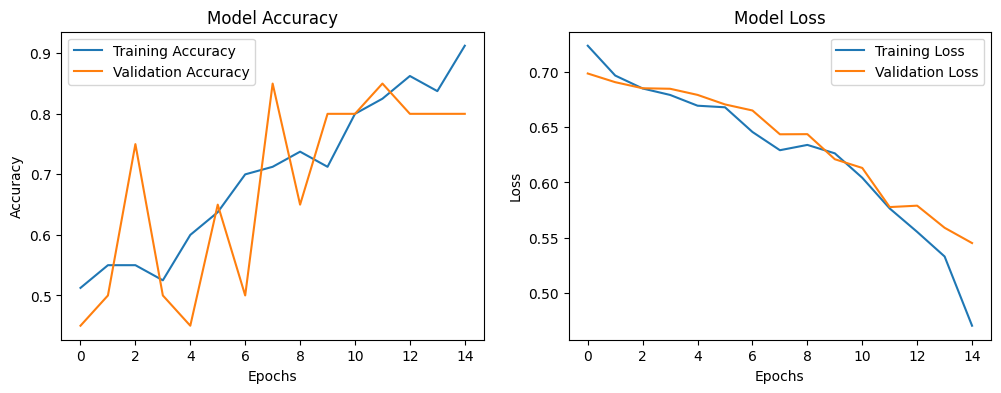

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


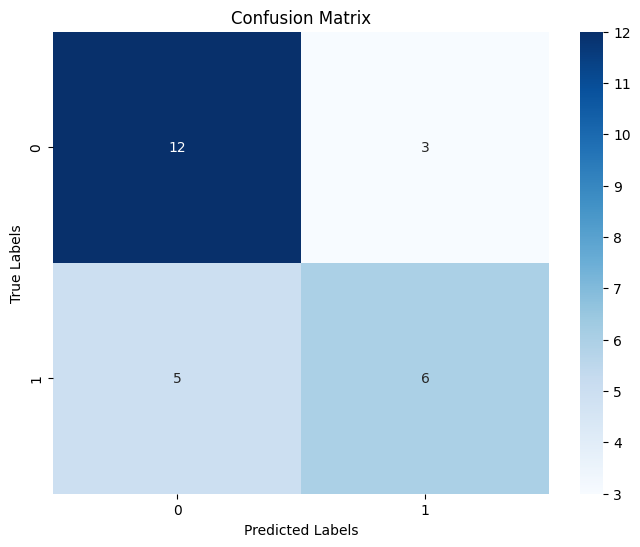

In [ ]:
base_path =path
real_audio_dir = os.path.join(base_path, "Real", "Real")
fake_audio_dir = os.path.join(base_path, "Fake", "Fake")

real_paths = [os.path.join(real_audio_dir, f) for f in os.listdir(real_audio_dir) if f.endswith('.wav')]
fake_paths = [os.path.join(fake_audio_dir, f) for f in os.listdir(fake_audio_dir) if f.endswith('.wav')]


x, y = prepare_dataset(real_paths, fake_paths)
x_augmented, y_augmented = augment_data(x, y)

# Pad sequences
max_length = max(len(seq) for seq in x_augmented)
x_padded = pad_sequences(x_augmented, maxlen=max_length, padding='post', dtype='float32', truncating='post')

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_padded, y_augmented, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Create and train model
model = create_model(input_shape=(x_train.shape[1], x_train.shape[2]))
history = train_and_evaluate(model, x_train, y_train, x_test, y_test)
plot_train_history(history)

# Predict and evaluate
y_pred = model.predict(x_test)
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.save("my_trained_model.h5")


In [ ]:
import librosa
import numpy as np


# Function to load and preprocess a new audio file
def preprocess_new_audio(audio_path, max_length):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=None)

    # Extract MFCC features (13 coefficients, modify n_mfcc if needed)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

    # Transpose to match the input shape
    mfccs = mfccs.T

    # Check if the length of mfccs is greater than max_length
    if len(mfccs) < max_length:
        # Pad the sequence if it's smaller than max_length
        mfccs_padded = np.pad(mfccs, ((0, max_length - len(mfccs)), (0, 0)), mode='constant')
    else:
        # Truncate the sequence if it's larger than max_length
        mfccs_padded = mfccs[:max_length]

    return np.expand_dims(mfccs_padded, axis=0)  # Add batch dimension


# Load new audio file
new_audio_path = "/content/Recording (18).wav"  # Provide path to your new audio file
max_length = 174  # Replace with actual max length from training data
new_audio_features = preprocess_new_audio(new_audio_path, max_length)

# Load the saved model (assuming you have already saved it)
from tensorflow.keras.models import load_model

model = load_model("/content/my_trained_model.h5")

# Make a prediction with the trained model
predictions = model.predict(new_audio_features)

# Convert prediction probabilities to class labels (0 or 1)
predicted_class = np.argmax(predictions, axis=1)

# Output the result
if predicted_class == 0:
    print("The audio is classified as 'REAL'.")
else:
    print("The audio is classified as 'FAKE'.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
The audio is classified as 'FAKE'.
